In [2]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp

import matplotlib.pyplot as plt
import os
from __future__ import annotations
import itertools
%matplotlib widget

from typing import TypeAlias, Iterator, Iterable
Vector: TypeAlias = np.ndarray  # A 1-D array
Matrix: TypeAlias = np.ndarray  # A 2-D array

In [3]:
class LayerInitializationStrategy:
    """Parent class for initialization strategies of weights and biases in Layer."""
    def run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]:
        raise NotImplementedError("The 'run' method is implemented only in child classes")

class RandomUniform(LayerInitializationStrategy):
    """
    Initialization strategy sampling weights and biases uniformly in a given interval.

    Attributes
    ----------
    scale: float
        The half-lenght of the interval [center-scale, center+scale] from which values are sampled.
    center: float
        The center of the aforementioned interval.

    Methods
    -------
    run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]
        Returns the tuple (random_weights, random_biases), where random_weights and random_biases are np.ndarrays of the appropriate shape.
    """
    def __init__(self, scale_of_interval: float, center_of_interval: float = 0):
        self.scale: float = scale_of_interval
        self.center: float = center_of_interval
        
    
    def run(self, size_of_previous_layer: int, size_of_current_layer: int) -> tuple[np.ndarray, np.ndarray]:
        random_weights: np.ndarray = np.random.uniform(
            -self.scale + self.center, self.scale + self.center,
            (size_of_previous_layer, size_of_current_layer)
            )
        random_biases: np.ndarray = np.random.uniform(
            -self.scale + self.center, self.scale + self.center,
            size_of_current_layer
            )
        return random_weights, random_biases
    
    def __str__(self):
        return f"Initialization: RandomUniform in [{self.center - self.scale}, {self.center + self.scale}]"

In [4]:
class ActivationFunction:
    """Parent class for activation functions of neural nodes."""
    def __call__(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError("The '__call__' method must be implemented in child classes")

    def derivative(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError("The 'derivative' method must be implemented in child classes")

class Sigmoid(ActivationFunction):
    """Sigmoid activation function. f(x) = 1 / (1 + np.exp(-x))"""
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        sigmoid = self(x)  # Reuse the __call__ method to compute sigmoid
        return sigmoid * (1 - sigmoid)
    
    def __str__(self):
        return "Sigmoid act. fun."

In [5]:
class Layer:
    """
    A Layer component of a NeuralNetwork.

    Attributes
    ----------
    unit_number: int
        The number of nodes/units in the Layer.
    init_strat: LayerInitializationStrategy
        The initialization strategy for the weights and biases of the Layer
    activation_function: ActivationFunction
        The function.
    """

    def __init__(self, number_of_units: int,
                 initialization_strategy: LayerInitializationStrategy,
                 activation_function: ActivationFunction):
        self.unit_number: int = number_of_units  # The number of nodes/units in the Layer.
        self.init_strat: LayerInitializationStrategy = initialization_strategy
        self.activation_function: ActivationFunction = activation_function

        # The values computed by the units, based on the outputs of the previous layer. Stored for later backprop.
        self.linear_output: Vector = None
        self.output: Vector = None
        
        # The layer preceding the current one in the Neural Network. The NN should connect layers during initialization.
        self.previous_layer: Layer = None
        self.next_layer: Layer = None

        # Weights and biases connecting the layer with the previous layer of the neural network.
        self.weights: Matrix = None; self.biases: Vector = None

        # A variable that needs to be computed from the delta of next layer in the
        # Backprop TrainingAlgorithm
        self.delta: Vector = None
        

    def initialize_weights(self) -> None:
        """
        Initialize the weights and biases of this Layer according to its init_strat.
        """
        self.weights, self.biases = self.init_strat.run(self.previous_layer.unit_number, self.unit_number)

    def compute_output(self):
        """
        Computes the output of this layer as activation_function(np.dot(input, weights) + biases), where
        the input is the output of the previous layer.
        Stores the output as well as just the linear_output np.dot(input, weights) + biases, as it's useful in typical training algorithms.
        """
        self.linear_output = np.dot(self.previous_layer.output, self.weights) + self.biases
        self.output: Vector = self.activation_function(self.linear_output)
        return self.output

class InputLayer(Layer):
    """
    The first Layer of a NeuralNetwork. It has no previous layer, and thus no weights and biases to connect it with.
    Its activation function is the Identity.

    Attributes
    ----------
    unit_number: int
        The number of nodes/units in the Layer.
    """
    def __init__(self, number_of_units: int):
        super().__init__(number_of_units, None, None)
        # An input layer has no previous layer to connect to, so attributes referring to a previous layer are deleted.
        del self.previous_layer, self.weights, self.biases, self.init_strat, self.activation_function
    
    def feed_input(self, value: Vector) -> None:
        """
        Sets the input (which is also the output) of the InputLayer, and thus of the whole NeuralNetwork, to value.
        """
        self.output: Vector = value
    
    def initialize_weights(self):
        raise NotImplementedError("InputLayer does not require weight initialization.")

    def compute_output(self) -> Vector:
        """
        Returns the output (which is also the input) of the InputLayer
        """
        return self.output

class HiddenLayer(Layer):
    def backward(self):
        """
        Computes the delta of this layer from the delta of the next layer
        as np.dot(self.next_layer.weights, self.next_layer.delta) * self.activation_function.derivative(self.linear_output)
        """
        self.delta = np.dot(self.next_layer.weights, self.next_layer.delta) * self.activation_function.derivative(self.linear_output)

class OutputLayer(Layer):
    def __init__(self, number_of_units: int,
                 initialization_strategy: LayerInitializationStrategy,
                 activation_function: ActivationFunction):
        super().__init__(number_of_units, initialization_strategy, activation_function)
        del self.next_layer

In [6]:
class ListOfArrays:
    """
    An utility class for defining element-wise operations on lists containing heteromorphic np.ndarrays.
    Useful for conveniently manipulating network weights and biases in MLP-architecture NeuralNetworks.
    """
    def __init__(self, arrays: list[np.ndarray]):
        self.arrays: list[np.ndarray] = arrays
    
    def __repr__(self):
        return f"ListOfArrays{(self.arrays)}"

    def __getitem__(self, index):
        return self.arrays[index]

    def __setitem__(self, index, value):
        self.arrays[index] = value
    
    def __add__(self, other):
        if isinstance(other, ListOfArrays):
            return ListOfArrays([x + y for x, y in zip(self.arrays, other.arrays)])
        elif np.isscalar(other):
            return ListOfArrays([x + other for x in self.arrays])
        else:
            raise TypeError("Operand must be a ListOfArrays or a scalar.")

    def __radd__(self, other):
        return self.__add__(other)        
    
    def __mul__(self, other):
        if isinstance(other, ListOfArrays):
            return ListOfArrays([x * y for x, y in zip(self.arrays, other.arrays)])
        elif np.isscalar(other):
            return ListOfArrays([x * other for x in self.arrays])
        else:
            raise TypeError("Operand must be a ListOfArrays or a scalar.")
    
    def __rmul__(self, other):
        return self.__mul__(other)

    def __truediv__(self, other):
        if isinstance(other, ListOfArrays):
            return ListOfArrays([x / y for x, y in zip(self.arrays, other.arrays)])
        elif np.isscalar(other):
            return ListOfArrays([x / other for x in self.arrays])
        else:
            raise TypeError("Operand must be a ListOfArrays or a scalar.")
    
    def __pow__(self, power: float):
        return ListOfArrays([x**power for x in self.arrays])
    
    def sum(self) -> float:
        return np.sum([np.sum(array) for array in self.arrays])
    
    def set_all_values_to(self, value: float) -> None:
        for a in self.arrays:
            a = value*np.ones(a.shape)


class ListOfVectors(ListOfArrays):
    """
    An utility class for convenient manipulation of lists of Vectors of different lengths.
    Useful for network biases in MLP-architecture NeuralNetworks.
    """
    def __init__(self, arrays: list[Vector]):
        super().__init__(arrays)

class ListOfMatrices(ListOfArrays):
    """
    An utility class for convenient manipulation of lists of Matrices of different number of rows and cols.
    Useful for network weights in MLP-architecture NeuralNetworks.
    """
    pass
    def __init__(self, arrays: list[Matrix]):
        super().__init__(arrays)

In [7]:
class MachineLearningModel:
    pass

class NeuralNetworkArchitecture:
    """
    An utility class for storing information about the number of Layers and of units for each Layer of a NeuralNetwork, as well as other
    useful data.

    Used for an alternative constructor of NeuralNetwork when no fine-control for initialization is needed.
    """
    def __init__(self, sizes_of_layers: list[int], activation_function: ActivationFunction, initialization_strategy: LayerInitializationStrategy):
        self.sizes_of_layers: list[int] = sizes_of_layers
        self.activation_function: ActivationFunction = activation_function
        self.initialization_strategy: LayerInitializationStrategy = initialization_strategy
    
    def __str__(self):
        network_shape: str = "(" + ", ".join(map(str, self.sizes_of_layers)) + ")"
        return f"{network_shape}"

class NeuralNetwork(MachineLearningModel):
    """
    A NeuralNetwork.

    Attributes
    ----------
    layers: list[Layer]
        The list of Layer that make the NeuralNetwork.
        Most NeuralNetwork methods work by invoking the appropriate Layer-level methods in the appropriate order.
    input_layer: Layer
        The first Layer of the NN
    hidden_layers: list[Layer]
        The list of non-first-nor-last Layers.
    output_layer: Layer
        The last Layer of the NN
    layers_with_weights: list[Layer]
        The list of all Layers, except the InputLayer.
    """
    def __init__(self, layers: list[Layer]):
        self.layers: list[Layer] = layers
        # Maybe here I should ensure that layers are correctly typed (layers[0] should be an InputLayer, layers[-1] an OutputLayer, all other layers should be HiddenLayer).
        self.input_layer: InputLayer = layers[0]; self.hidden_layers: list[HiddenLayer] = layers[1: -1]; self.output_layer: OutputLayer = layers[-1]
        self.layers_with_weights: list[Layer] = self.layers[1: ]
        self.connect_layers()
        self.initialize_weights()

    @classmethod
    def FromArchitecture(cls, architecture: NeuralNetworkArchitecture):
        sizes: list[int] = architecture.sizes_of_layers; act_fun = architecture.activation_function; init_strat = architecture.initialization_strategy
        il: InputLayer = InputLayer(sizes[0])
        hls: list[HiddenLayer] = [HiddenLayer(n, init_strat, act_fun) for n in sizes[1: -1]]
        ol: OutputLayer = OutputLayer(sizes[-1], init_strat, act_fun)
        layers: list[Layer] = [il] + hls + [ol]
        return cls(layers)

    def connect_layers(self) -> None:
        for (i, layer) in enumerate(self.layers):
            if not isinstance(layer, InputLayer): layer.previous_layer = self.layers[i - 1]
            if not isinstance(layer, OutputLayer): layer.next_layer = self.layers[i + 1]

    def initialize_weights(self) -> None:
        for layer in self.layers_with_weights: layer.initialize_weights()
    
    def feed_input(self, value: np.ndarray) -> None:
        self.input_layer.feed_input(value)

    def activate_network(self) -> np.ndarray:
        for i in range(len(self.layers)): self.layers[i].compute_output()
        return self.output_layer.output
    
    def compute_output(self, value: np.ndarray) -> np.ndarray:
        self.feed_input(value)
        return self.activate_network()
    
    def backward(self) -> None:
        for l in reversed(self.hidden_layers):
            l.backward()
    
    def compute_multiple_outputs(self, x_data: pd.DataFrame | np.ndarray) -> np.ndarray[np.ndarray]:
        if isinstance(x_data, pd.DataFrame): x_data = x_data.to_numpy()
        outputs = np.array(
            [
                self.compute_output(x_data[i]) for i in range(len(x_data))
            ]
        )
        return outputs

In [8]:
class RegularizationTerm:
    def set_network(self, network: NeuralNetwork) -> None:
        self.network = network

    def __call__(self) -> float:
        pass

    def gradient(self) -> tuple[ListOfArrays, ListOfArrays]:
        pass

class NoRegularization(RegularizationTerm):
    def __init__(self):
        pass

    def __call__(self) -> float:
        return 0
    
    def gradient(self) -> tuple[ListOfArrays, ListOfArrays]:
        layers = self.network.layers_with_weights
        return ListOfArrays([np.zeros_like(l.weights) for l in layers]), ListOfArrays([np.zeros_like(l.biases) for l in layers])
    
    def __str__(self):
        return "No reg."

class Tikhonov(RegularizationTerm):
    """
    A regularization penalty term of the form constant*(sum of squares of weights and biases).

    Parameters
    ----------
    penalty: float
        The constant factor multiplying the sum of squares.
    
    Attributes
    ----------
    penalty: float
        The constant factor multiplying the sum of squares.
    network: NeuralNetwork
        The NeuralNetwork that weights and biases are read from.
    """
    def __init__(self, penalty: float):
        self.penalty: float = penalty
        self.network: NeuralNetwork = None

    def __call__(self) -> float:
        layers: list[Layer] = self.network.layers_with_weights
        weights_term = np.sum([np.sum(layer.weigths**2) for layer in layers])  # The sum of squares of all the weights in the NN.
        biases_term = np.sum([np.sum(layer.biases**2) for layer in layers])
        return self.penalty * (weights_term + biases_term) / 2

    def gradient(self) -> tuple[ListOfArrays, ListOfArrays]:
        layers: list[Layer] = self.network.layers_with_weights
        gradient_on_weights: ListOfArrays = ListOfArrays([-self.penalty * l.weights for l in layers])
        gradient_on_biases: ListOfArrays = ListOfArrays([-self.penalty * l.biases for l in layers])
        return gradient_on_weights, gradient_on_biases
    
    def __str__(self):
        return f"Tikhonov({self.penalty})"

In [9]:
class MomentumRule:
    def update(self, new_weights_term: ListOfMatrices, new_biases_term: ListOfVectors) -> None:
        pass
    
    @property
    def weights_term(self) -> ListOfMatrices:
        pass

    @property
    def biases_term(self) -> ListOfVectors:
        pass


class NoMomentum(MomentumRule):
    @property
    def weights_term(self) -> ListOfMatrices:
        return 0

    @property
    def biases_term(self) -> ListOfVectors:
        return 0

class ClassicalMomentum(MomentumRule):
    def __init__(self, decay_factor: float):
        self.decay_factor: float = decay_factor
        self.weights_term_old: ListOfMatrices = 0; self.biases_term_old: ListOfVectors = 0
        self.weights_term_new: ListOfMatrices = 0; self.biases_term_new: ListOfVectors = 0
    
    def update(self, new_weights_term: ListOfMatrices, new_biases_term: ListOfVectors) -> None:
        self.weights_term_old = self.weights_term_new; self.biases_term_old = self.biases_term_new
        self.weights_term_new = self.weights_term_old * self.decay_factor + new_weights_term
        self.biases_term_new = self.biases_term_old * self.decay_factor + new_biases_term
    
    @property
    def weights_term(self) -> ListOfMatrices:
        return self.weights_term_old

    @property
    def biases_term(self) -> ListOfVectors:
        return self.biases_term_old


class NesterovMomentum(MomentumRule):
    def __init__(self, decay_factor: float):
        self.decay_factor: float = decay_factor
        self.w_term: ListOfMatrices = 0; self.b_term: ListOfVectors = 0

    def update(self, new_weights_term: ListOfMatrices, new_biases_term: ListOfVectors) -> None:
        self.w_term = self.w_term * self.decay_factor + new_weights_term
        self.b_term = self.b_term * self.decay_factor + new_biases_term
    
    @property
    def weights_term(self) -> ListOfMatrices:
        return self.w_term

    @property
    def biases_term(self) -> ListOfVectors:
        return self.b_term

In [10]:
class StoppingCondition:
    def __init__(self):
        self.alg: TrainingAlgorithm = None
    
    def set_alg(self, alg: TrainingAlgorithm) -> None:
        self.alg = alg

    @property
    def is_satisfied(self) -> bool:
        pass

class ThresholdOnTrainingError(StoppingCondition):
    """
    Parameters
    ----------
    threshold: float
    patience: int
    """
    def __init__(self, threshold: float, patience: int):
        super().__init__()
        self.threshold: float = threshold
        self.patience: int = patience
    
    @property
    def is_satisfied(self) -> bool:
        current_training_error: float = self.alg.current_tr_err
        if current_training_error < self.threshold:
            self.consecutive_epochs += 1
            return self.consecutive_epochs > self.patience
        else:
            self.consecutive_epochs = 0
            return False
    
    def __str__(self):
        return f"TR Err threshold: {self.threshold}"

In [11]:
class ErrorFunction:
    def __call__(self, y_data: np.ndarray, y_predicted: np.ndarray) -> float:
        pass
    
    def simple_gradient(self, y_data: np.ndarray, y_predicted: np.ndarray) -> np.ndarray:
        pass

class MSE(ErrorFunction):
    def __call__(self, y_data: np.ndarray, y_predicted: np.ndarray) -> float:
        """
        Returns the average over the dataset of the square euclidean distance between the training outputs and the predictions.
        """
        num_patterns = 1 if y_data.ndim == 1 else len(y_data)
        return 0.5 * np.sum((y_data - y_predicted)**2) / num_patterns
    
    def simple_gradient(self, y_data: np.ndarray, y_predicted: np.ndarray) -> np.ndarray:
        """
        Returns y_data - y_predicted. It is meant to be used on a single pattern at a time, during backpropagation.
        """
        return (y_data - y_predicted)
    
    def __str__(self):
        return "MSE"

In [12]:
class Dataset:
    def __init__(self, x_data: Matrix, y_data: Matrix):
        """
        Initializes the dataset with input (x_data) and output (y_data).
        """

        if isinstance(x_data, pd.DataFrame): x_data = x_data.to_numpy()
        if isinstance(y_data, pd.DataFrame): y_data = y_data.to_numpy()
        
        if x_data.ndim == 1 or y_data.ndim == 1:
            raise ValueError(f"x_data and y_data should be matrices, where each row represents a pattern and each column a feature, but got arguments of shape {x_data.shape} and {y_data.shape}")

        self.x: Matrix = x_data
        self.y: Matrix = y_data
    
    def __len__(self):
        """
        Returns the number of patterns in the dataset.
        """
        return len(self.x)
    
    def __getitem__(self, index):
        """
        Retrieves the input-output pair at the specified index.
        """
        if isinstance(index, slice):
            return Dataset(self.x[index], self.y[index])
        # This should be refactored in the future. The behaviour should be the same as numpy, regardless of index type.
        elif isinstance(index, list) or isinstance(index, np.ndarray):
            return Dataset(self.x[index], self.y[index])
        return self.x[index], self.y[index]
    
    def shuffle(self) -> None:
        indices: np.ndarray = np.arange(len(self))
        np.random.shuffle(indices)
        self.x = self.x[indices, :]
        self.y = self.y[indices, :]
    
    def split(self, fraction: float, shuffle: bool = True) -> tuple[Dataset, Dataset]:
        """
        Returns two datasets, one with fraction*N data and the other with (1-fraction)*N.
        """
        indices: np.ndarray = np.arange(len(self))
        
        if shuffle:
            np.random.shuffle(indices)
        splitting_number: int = int(fraction * len(self))
        indices_1: np.ndarray = indices[:splitting_number]
        
        indices_2: np.ndarray = indices[splitting_number:]
        ds_1: Dataset = Dataset(self.x[indices_1, :], self.y[indices_1, :])
        ds_2: Dataset = Dataset(self.x[indices_2, :], self.y[indices_2, :])
        return ds_1, ds_2
    
    @classmethod
    def concatenate(cls, datasets: Iterable[Dataset]) -> Dataset:
        x = np.concatenate([ds.x for ds in datasets])
        y = np.concatenate([ds.y for ds in datasets])
        return Dataset(x, y)


class DataManager:
    """An auxiliary class for extracting minibatches from a Dataset."""
    def __init__(self, dataset: Dataset, minibatch_size: int = None, shuffle: bool = True):
        self.dataset: Dataset = dataset
        self.minibatch_size: int = minibatch_size or len(dataset)
        self.shuffle: bool = shuffle
    
    def __iter__(self):
        """
        An iterator yielding minibatches.
        """
        indices = np.arange(len(self.dataset))
        
        if self.shuffle:
            np.random.shuffle(indices)
        
        for start in range(0, len(indices), self.minibatch_size):
            minibatch_indices = indices[start:start + self.minibatch_size]
            minibatch_x = self.dataset.x[minibatch_indices, :]
            minibatch_y = self.dataset.y[minibatch_indices, :]
            yield minibatch_x, minibatch_y

In [13]:
class Keys:
    ARCHITECTURE = "architecture"
    TR_ALGORITHM = "training algorithm"
    HYP_COMB = "hyperparameters combination"
    TR_ERROR = "training error"
    TR_CURVE = "training curve"
    VL_ERROR = "validation error"
    VL_CURVE = "validation curve"

In [14]:
class TrainingAlgorithm:
    def __init__(self, x_train: pd.DataFrame, y_train: pd.DataFrame, network: NeuralNetwork):
        self.network: NeuralNetwork = network

        if isinstance(x_train, pd.DataFrame): x_train = x_train.to_numpy()
        if isinstance(y_train, pd.DataFrame): y_train = y_train.to_numpy()

        self.training_set = Dataset(x_train, y_train)

        self.current_tr_err: float = float('inf')

        self.history: dict[list] = {Keys.TR_ERROR: []}
        self.cache: dict = {}

class Backprop(TrainingAlgorithm):
    def __init__(self, x_train: pd.DataFrame, y_train: pd.DataFrame, network: NeuralNetwork,
                 learning_rate: float,
                 error_function: ErrorFunction,
                 stopping_condition: StoppingCondition,
                 regularization_term: RegularizationTerm = None,
                 minibatch_size: int = None
                 ):
        super().__init__(x_train, y_train, network)

        self.learning_rate: float = learning_rate

        self.err_fun: ErrorFunction = error_function
        
        self.stop_cond: StoppingCondition = stopping_condition
        self.stop_cond.set_alg(self)

        self.weights_gradient: ListOfMatrices = ListOfMatrices([np.zeros_like(l.weights) for l in self.network.layers_with_weights])
        self.biases_gradient: ListOfVectors = ListOfVectors([np.zeros_like(l.biases) for l in self.network.layers_with_weights])

        self.regularization_term: RegularizationTerm = regularization_term or NoRegularization()
        self.regularization_term.set_network(self.network)

        self.minibatch_size: int = minibatch_size or len(self.training_set)
        self.minibatch_generator: DataManager = DataManager(self.training_set, self.minibatch_size,
                                                            shuffle = (self.minibatch_size != len(self.training_set))
                                                            )
        
        
        self.current_mb_size: int = None
        self.current_mb_x: Matrix = None; self.current_mb_y: Matrix = None
        
    
    def run(self, max_epochs: int) -> None:
        epoch: int = 0
        while epoch < max_epochs:
            epoch += 1

            for minibatch_x, minibatch_y in self.minibatch_generator:
                self.update_minibatch_metadata(minibatch_x, minibatch_y)
                self.update_gradients()
                self.update_network_parameters()
            
            self.compute_training_error()
            if self.stop_cond.is_satisfied: break

    def update_minibatch_metadata(self, minibatch_x: Matrix, minibatch_y: Matrix):
        self.current_mb_x = minibatch_x; self.current_mb_y = minibatch_y
        self.current_mb_size = len(minibatch_x)
    
    def update_gradients(self):
        self.reset_gradients()

        for x, y in zip(self.current_mb_x, self.current_mb_y):
            predicted_y = self.network.compute_output(x)
            out_l = self.network.output_layer
            out_l.delta = self.err_fun.simple_gradient(y, predicted_y)*out_l.activation_function.derivative(out_l.linear_output)
            self.network.backward()
            self.weights_gradient += ListOfMatrices([np.outer(l.previous_layer.output, l.delta) for l in self.network.layers_with_weights])
            self.biases_gradient += ListOfVectors([l.delta for l in self.network.layers_with_weights])
        self.weights_gradient /= self.current_mb_size; self.biases_gradient /= self.current_mb_size

        self.add_regul_contribution()
        self.add_momentum_contribution()
    
    def reset_gradients(self) -> None:
        self.weights_gradient.set_all_values_to(0)
        self.biases_gradient.set_all_values_to(0)
    
    def add_regul_contribution(self) -> None:
        contribution_to_w, contribution_to_b = self.regularization_term.gradient()
        self.weights_gradient += contribution_to_w; self.biases_gradient += contribution_to_b

    def add_momentum_contribution(self) -> None:
        pass
    
    def update_network_parameters(self) -> None:
        factor = self.learning_rate * self.current_mb_size / len(self.training_set)
        
        for i, l in enumerate(self.network.layers_with_weights):
            l.weights += factor * self.weights_gradient[i]
            l.biases += factor * self.biases_gradient[i]

    def compute_training_error(self) -> None:
        y_prediction = self.network.compute_multiple_outputs(self.training_set.x)
        self.current_tr_err = self.err_fun(self.training_set.y, y_prediction)
        self.history[Keys.TR_ERROR] += [self.current_tr_err]



In [15]:
class TrainingAlgorithm:
    def __init__(self, x_train: pd.DataFrame, y_train: pd.DataFrame, network: NeuralNetwork):
        self.network: NeuralNetwork = network

        if isinstance(x_train, pd.DataFrame): x_train = x_train.to_numpy()
        if isinstance(y_train, pd.DataFrame): y_train = y_train.to_numpy()

        self.training_set = Dataset(x_train, y_train)

        self.current_tr_err: float = float('inf')

        self.history: dict[list] = {Keys.TR_ERROR: []}

class GradientDescentAlgorithm(TrainingAlgorithm):
    def __init__(self, x_train: pd.DataFrame, y_train: pd.DataFrame, network: NeuralNetwork,
                 learning_rate: float,
                 error_function: ErrorFunction,
                 stopping_condition: StoppingCondition,
                 regularization_term: RegularizationTerm = None,
                 momentum_rule: MomentumRule = None,
                 minibatch_size: int = None
                 ):
        # Initialize parameters given in __init__
        super().__init__(x_train, y_train, network)
        self.learning_rate: float = learning_rate
        self.err_fun: ErrorFunction = error_function
        self.stop_cond: StoppingCondition = stopping_condition; self.stop_cond.set_alg(self)
        self.regularization_term: RegularizationTerm = regularization_term or NoRegularization()
        self.regularization_term.set_network(self.network)
        self.momentum: MomentumRule = momentum_rule or NoMomentum()
        self.minibatch_size: int = minibatch_size or len(self.training_set)

        # Initialize attributes used for later computations.
        self.weights_gradient: ListOfMatrices = ListOfMatrices([np.zeros_like(l.weights) for l in self.network.layers_with_weights])  # Gradients of the - loss function (= error function + regularization penalty)
        self.biases_gradient: ListOfVectors = ListOfVectors([np.zeros_like(l.biases) for l in self.network.layers_with_weights])      # with respect to, respectively, weights and biases of the NeuralNetwork.

        self.weights_update: ListOfMatrices = ListOfMatrices([np.zeros_like(l.weights) for l in self.network.layers_with_weights])  # Update terms for, respectively, weights and biases of the NeuralNetwork, computed 
        self.biases_update: ListOfVectors = ListOfVectors([np.zeros_like(l.biases) for l in self.network.layers_with_weights])      # according to the particular GradientDescentAlgorithm's update rules. Momentum is not included.

        self.minibatch_generator: DataManager = DataManager(self.training_set, self.minibatch_size,
                                                            shuffle = (self.minibatch_size != len(self.training_set))
                                                            )
        self.current_mb_size: int = None
        self.current_mb_x: Matrix = None; self.current_mb_y: Matrix = None
    

    def run(self, max_epochs: int) -> None:
        epoch: int = 0
        while epoch < max_epochs:
            epoch += 1
            self.do_epoch_training()
            self.compute_training_error()
            self.store_training_error()
            if self.stop_cond.is_satisfied: break
    
    def do_epoch_training(self) -> None:
        for minibatch_x, minibatch_y in self.minibatch_generator:
            self.update_minibatch_metadata(minibatch_x, minibatch_y)
            self.compute_necessary_quantities_for_network_update()
            self.update_network_parameters()
    
    def update_minibatch_metadata(self, minibatch_x: Matrix, minibatch_y: Matrix):
        self.current_mb_x = minibatch_x; self.current_mb_y = minibatch_y
        self.current_mb_size = len(minibatch_x)

    def compute_necessary_quantities_for_network_update(self) -> None:
        raise NotImplementedError("This method should be implemented in child classes of GradientDescentAlgorithm.")

    def compute_gradients(self) -> None:
        # Reset gradients to 0.
        self.reset_gradients()
        # Sum the gradient of error function term, obtained via backpropagation, for each data point in the minibatch.
        for x, y in zip(self.current_mb_x, self.current_mb_y):
            # Manually compute and set the delta for the output layer.
            predicted_y = self.network.compute_output(x)
            out_l = self.network.output_layer
            out_l.delta = self.err_fun.simple_gradient(y, predicted_y)*out_l.activation_function.derivative(out_l.linear_output)
            # Use backpropagation to set the deltas for all layers.
            self.network.backward()
            # Sum the appropriate quantities to the gradient.
            self.weights_gradient += ListOfMatrices([np.outer(l.previous_layer.output, l.delta) for l in self.network.layers_with_weights])
            self.biases_gradient += ListOfVectors([l.delta for l in self.network.layers_with_weights])
        # Divide by the number of examples in the minibatch to get an average.
        self.weights_gradient /= self.current_mb_size; self.biases_gradient /= self.current_mb_size
        # Add regularization term contributions to the gradients.
        contribution_to_w, contribution_to_b = self.regularization_term.gradient()
        self.weights_gradient += contribution_to_w; self.biases_gradient += contribution_to_b

    def reset_gradients(self) -> None:
        # Reset gradients to 0.
        self.weights_gradient.set_all_values_to(0)
        self.biases_gradient.set_all_values_to(0)

    def update_momentum_terms(self) -> None:
        self.momentum.update(self.weights_update, self.biases_update)

    def update_network_parameters(self) -> None:
        for i, l in enumerate(self.network.layers_with_weights):
            l.weights += (self.weights_update + self.momentum.weights_term)[i]
            l.biases += (self.biases_update + self.momentum.biases_term)[i]
    
    def compute_training_error(self) -> None:
        y_prediction = self.network.compute_multiple_outputs(self.training_set.x)
        self.current_tr_err = self.err_fun(self.training_set.y, y_prediction)
    
    def store_training_error(self) -> None:
        self.history[Keys.TR_ERROR] += [self.current_tr_err]

class ClassicalBackprop(GradientDescentAlgorithm):
    def compute_necessary_quantities_for_network_update(self) -> None:
        self.compute_gradients()

        factor = self.learning_rate*self.current_mb_size / len(self.training_set)
        self.weights_update = factor * self.weights_gradient
        self.biases_update = factor * self.biases_gradient

        self.momentum.update(self.weights_update, self.biases_update)

class AdaGrad(GradientDescentAlgorithm):
    def __init__(self, x_train, y_train, network, learning_rate, error_function, stopping_condition, regularization_term = None, momentum_rule = None, minibatch_size = None,
                 epsilon: float = 1e-10
                 ):
        super().__init__(x_train, y_train, network, learning_rate, error_function, stopping_condition, regularization_term, momentum_rule, minibatch_size)
        self.epsilon: float = epsilon  # A small numerical value used in the denominator of the weights and biases updates to prevent division by 0.

        self.sum_w_grad_squares: ListOfMatrices = ListOfMatrices([np.zeros_like(l.weights) for l in self.network.layers_with_weights])
        self.sum_b_grad_squares: ListOfVectors = ListOfVectors([np.zeros_like(l.biases) for l in self.network.layers_with_weights])
    
    def compute_necessary_quantities_for_network_update(self) -> None:
        self.compute_gradients()

        self.accumulate_grad_squares()
        factor = self.learning_rate*self.current_mb_size / len(self.training_set)
        self.weights_update = factor * self.weights_gradient / (self.sum_w_grad_squares + self.epsilon)**0.5
        self.biases_update = factor * self.biases_gradient / (self.sum_b_grad_squares + self.epsilon)**0.5
        
        self.update_momentum_terms()
    
    def accumulate_grad_squares(self) -> None:
        self.sum_w_grad_squares += self.weights_gradient**2
        self.sum_b_grad_squares += self.biases_gradient**2

class RMSProp(GradientDescentAlgorithm):
    def __init__(self, x_train, y_train, network, learning_rate, error_function, stopping_condition,
                 forgetting_factor: float,
                 regularization_term = None, momentum_rule = None, minibatch_size = None,
                 epsilon: float = 1e-10):
        super().__init__(x_train, y_train, network, learning_rate, error_function, stopping_condition, regularization_term, momentum_rule, minibatch_size)
        self.epsilon: float = epsilon  # A small numerical value used in the denominator of the weights and biases updates to prevent division by 0.
        self.forgetting_factor: float = forgetting_factor

        self.avg_w_grad_squares: ListOfMatrices = ListOfMatrices([np.zeros_like(l.weights) for l in self.network.layers_with_weights])
        self.avg_b_grad_squares: ListOfVectors = ListOfVectors([np.zeros_like(l.biases) for l in self.network.layers_with_weights])
    
    def compute_necessary_quantities_for_network_update(self) -> None:
        self.compute_gradients()

        self.update_averages()
        factor = self.learning_rate*self.current_mb_size / len(self.training_set)
        self.weights_update = factor * self.weights_gradient / (self.avg_w_grad_squares + self.epsilon)**0.5
        self.biases_update = factor * self.biases_gradient / (self.avg_b_grad_squares + self.epsilon)**0.5
        
        self.update_momentum_terms()

    def update_averages(self) -> None:
        self.avg_w_grad_squares = self.forgetting_factor * self.avg_w_grad_squares + (1 - self.forgetting_factor) * self.weights_gradient ** 2
        self.avg_b_grad_squares = self.forgetting_factor * self.avg_b_grad_squares + (1 - self.forgetting_factor) * self.biases_gradient ** 2

class Adam(GradientDescentAlgorithm):
    def __init__(self, x_train, y_train, network, learning_rate,
                 beta_1: float, beta_2: float,
                 error_function, stopping_condition, regularization_term = None, momentum_rule = None, minibatch_size = None,
                 epsilon: float = 1e-10):
        super().__init__(x_train, y_train, network, learning_rate, error_function, stopping_condition, regularization_term, momentum_rule, minibatch_size)
        self.beta_1: float = beta_1
        self.beta_2: float = beta_2
        self.epsilon: float = epsilon
        self.current_tr_iteration: int = 0

        self.avg_w_grad: ListOfMatrices = ListOfMatrices([np.zeros_like(l.weights) for l in self.network.layers_with_weights])
        self.avg_b_grad: ListOfVectors = ListOfVectors([np.zeros_like(l.biases) for l in self.network.layers_with_weights])

        self.avg_w_grad_squares: ListOfMatrices = ListOfMatrices([np.zeros_like(l.weights) for l in self.network.layers_with_weights])
        self.avg_b_grad_squares: ListOfVectors = ListOfVectors([np.zeros_like(l.biases) for l in self.network.layers_with_weights])
    
    def compute_necessary_quantities_for_network_update(self) -> None:
        self.compute_gradients()

        self.update_averages()
        factor = self.learning_rate*self.current_mb_size / len(self.training_set)
        self.current_tr_iteration += 1
        self.weights_update = factor * ( self.avg_w_grad / (1 - self.beta_1**self.current_tr_iteration) ) / (( self.avg_w_grad_squares / (1 - self.beta_2**self.current_tr_iteration))**0.5 + self.epsilon)
        self.biases_update = factor * ( self.avg_b_grad / (1 - self.beta_1**self.current_tr_iteration) ) / (( self.avg_b_grad_squares / (1 - self.beta_2**self.current_tr_iteration))**0.5 + self.epsilon)

        self.update_momentum_terms()
    
    def update_averages(self) -> None:
        self.avg_w_grad = self.beta_1 * self.avg_w_grad + (1 - self.beta_1) * self.weights_gradient
        self.avg_b_grad = self.beta_1 * self.avg_b_grad + (1 - self.beta_1) * self.biases_gradient

        self.avg_w_grad_squares = self.beta_2 * self.avg_w_grad_squares + (1 - self.beta_2) * self.weights_gradient ** 2
        self.avg_b_grad_squares = self.beta_2 * self.avg_b_grad_squares + (1 - self.beta_2) * self.biases_gradient ** 2

In [18]:
hyperparams: dict[list] = {
    'learning_rate': [10.9],
    'error_function': [MSE()],
    'stopping_condition': [ThresholdOnTrainingError(0.0001, 10)],
    'regularization_term': [Tikhonov(5e-5),
                            Tikhonov(5e-7),
                            NoRegularization()
                            ],
    'minibatch_size': [2]
}

list_of_architectures = [
        NeuralNetworkArchitecture([17, 4, 2], Sigmoid(), RandomUniform(0.3)),
        NeuralNetworkArchitecture([17, 5, 2], Sigmoid(), RandomUniform(0.3))
    ]

#grid = HyperparameterGrid(list_of_architectures, Backprop, hyperparams)

#l = grid.to_list()


monk2train_path = os.path.join('..', 'monk+s+problems', 'monks-2.train')
df = pd.read_csv(monk2train_path, sep = ' ', skipinitialspace= True, names= ['class', 'a1','a2','a3','a4','a5','a6', 'ID'])
raw_x = df.loc[:, 'a1':'a6']; raw_y = df.loc[:, 'class']
x = pd.get_dummies(raw_x, columns = raw_x.columns).astype(int); y = pd.get_dummies(raw_y).astype(int)


dataset = Dataset(x, y)


nn = NeuralNetwork.FromArchitecture(list_of_architectures[0])


training_alg = Adam(x, y, nn, 6.9,
                    0.9, 0.999, MSE(), ThresholdOnTrainingError(0.0001, 10), Tikhonov(1e-6), NoMomentum(), 2)

training_alg.run(200)

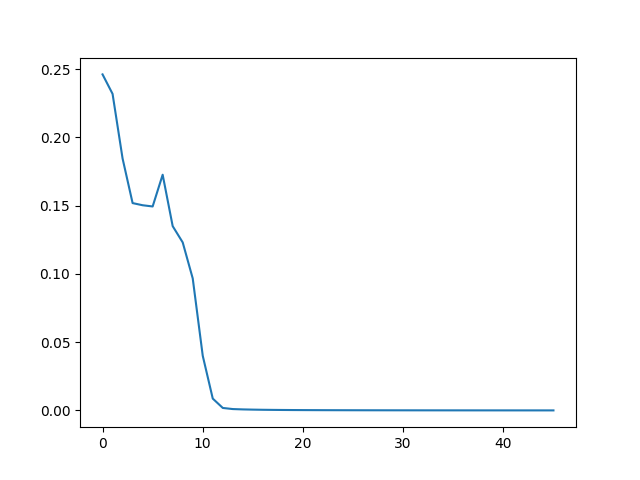

In [21]:
trcurve = training_alg.history[Keys.TR_ERROR]
plt.plot(trcurve)
plt.show()

In [20]:
plt.close()

In [14]:
import inspect

def check_tr_hyperparams(training_hyperparameters: dict, algorithm_class: type[TrainingAlgorithm]):
    signature = inspect.signature(algorithm_class.__init__)
    expected_hyparams = signature.parameters
    for hyparam_name in training_hyperparameters.keys():
        if hyparam_name not in expected_hyparams:
            raise ValueError(f"Unexpected parameter: {hyparam_name}")



def compute_network_error(network: NeuralNetwork, dataset: Dataset, error_function: ErrorFunction) -> float:
    y_prediction = network.compute_multiple_outputs(dataset.x)
    return error_function(dataset.y, y_prediction)



class HyperparameterCombination:
    def __init__(self,
                 architecture: NeuralNetworkArchitecture,
                 algorithm_class: type[TrainingAlgorithm],
                 training_hyperparameters: dict[str, object],
                 ensure_hyperparameter_compatibility: bool = True):
        self.architecture: NeuralNetworkArchitecture = architecture
        self.alg_cls: type[TrainingAlgorithm] = algorithm_class
        self.tr_hyp: dict[str, object] = training_hyperparameters

        if ensure_hyperparameter_compatibility:
            check_tr_hyperparams(self.tr_hyp, algorithm_class)
    
    def keys(self) -> list[str]:
        return [Keys.ARCHITECTURE, Keys.TR_ALGORITHM] + list(self.tr_hyp.keys())
    
    def training_hyperparameters_keys(self) -> list[str]:
        return self.tr_hyp.keys()
    
    def as_dict(self) -> dict[str, object]:
        return {Keys.ARCHITECTURE: str(self.architecture),
                Keys.TR_ALGORITHM: str(self.alg_cls.__name__),
                **{k: str(v) for k, v in self.tr_hyp.items()}
                }


class HyperparameterGrid:
    def __init__(self,
                 list_of_architectures: list[NeuralNetworkArchitecture],
                 algorithm_class: type[TrainingAlgorithm],
                 lists_of_training_hyperparameters: dict[str, list[object]]
                 ):
        self.architectures: list[NeuralNetworkArchitecture] = list_of_architectures
        self.alg_cls: type[TrainingAlgorithm] = algorithm_class
        self.tr_hyp_lists: dict[str, list[object]] = lists_of_training_hyperparameters

        self._list: list[HyperparameterCombination] = None  # Store the result of the to_list() method the first time it's called

        check_tr_hyperparams(self.tr_hyp_lists, algorithm_class)
    
    def to_list(self) -> list[HyperparameterCombination]:
        if self._list is None:
            self._list = []
            for arc in self.architectures:
                for tr_hyp_values in itertools.product(*self.tr_hyp_lists.values()):
                    tr_hyp: dict[str, object] = dict(zip(self.tr_hyp_lists.keys(), tr_hyp_values))
                    self._list.append(
                        HyperparameterCombination(arc, self.alg_cls, tr_hyp)
                    )
        return self._list


In [15]:
def parenthetical_uncertainty_format(number: float, uncertainty: float, uncertainty_digits: int = 2) -> str:
    import math
    num_exponent = math.floor(math.log10(abs(number))) if number != 0 else 0
    unc_exponent = math.floor(math.log10(abs(uncertainty))) if uncertainty != 0 else 0

    n = num_exponent - unc_exponent + 1  # Number of significant digits
    if n <= 0: return f"{number} +- {uncertainty}"
    scaled_number = number * 10 ** -num_exponent
    num_string = f"{scaled_number:.{n - 1 + uncertainty_digits - 1}f}"

    scaled_uncertainty = uncertainty * 10 ** -unc_exponent
    unc_string = f"{scaled_uncertainty:.{uncertainty_digits - 1}f}".replace('.', '')

    return f"{num_string}({unc_string})e{num_exponent}"

In [16]:
class ModelEvaluationMethod:
    pass



class SelectionMethod(ModelEvaluationMethod):
    pass

class HoldOutSelection(SelectionMethod):
    def __init__(self, training_set: Dataset, validation_set: Dataset,
                 hyperparameter_combinations: list[HyperparameterCombination],
                 risk_function: ErrorFunction
                 ):
        self.tr_set: Dataset = training_set
        self.vl_set: Dataset = validation_set
        self.hyp_combs: list[HyperparameterCombination] = hyperparameter_combinations
        self.risk_fun: ErrorFunction = risk_function

        self.results: dict[HyperparameterCombination, float] = {
            hyp_comb: None for hyp_comb in self.hyp_combs
        }  # Storage for the validation error of each combination of hyperparams.

        self.tr_err_curves: dict[HyperparameterCombination, list[float]] = {
            hyp_comb: [] for hyp_comb in self.hyp_combs
        }

        self.vl_err_curves: dict[HyperparameterCombination, list[float]] = {
            hyp_comb: [] for hyp_comb in self.hyp_combs
        }

        

    def run(self, max_epochs: int, trace_error = False) -> None:
        

        def process_single_hyp_comb(hyp_comb: HyperparameterCombination) -> dict[str, object]:

            out: dict[str, object] = {}
            arc, alg_cls, tr_hyp = hyp_comb.architecture, hyp_comb.alg_cls, hyp_comb.tr_hyp

            network = NeuralNetwork.FromArchitecture(arc)
            alg: TrainingAlgorithm = alg_cls(self.tr_set.x, self.tr_set.y, network, **tr_hyp)

            if trace_error:
                out[Keys.VL_CURVE] = []
                for _ in range(max_epochs):
                    alg.run(1)
                    vl_err: float = compute_network_error(network, self.vl_set, self.risk_fun)
                    out[Keys.VL_CURVE].append(vl_err)
                out[Keys.TR_CURVE] = alg.history[Keys.TR_ERROR]
            else:
                alg.run(max_epochs)
                vl_err: float = compute_network_error(network, self.vl_set, self.risk_fun)
            out[Keys.VL_ERROR] = vl_err
            
            return out

        single_hyp_comb_results: list[dict] = Parallel(n_jobs=-1)(
            delayed(process_single_hyp_comb)(hyp_comb) for hyp_comb in self.hyp_combs
        )
        for hyp_comb, hcr in zip(self.hyp_combs, single_hyp_comb_results):

            self.results[hyp_comb] = hcr[Keys.VL_ERROR]
            if Keys.VL_CURVE in hcr.keys(): self.vl_err_curves[hyp_comb] = hcr[Keys.VL_CURVE]
            if Keys.TR_CURVE in hcr.keys(): self.tr_err_curves[hyp_comb] = hcr[Keys.TR_CURVE]
    


    def results_dataframe(self) -> pd.DataFrame:
        out: list[dict] = []
        for k, v in self.results.items():
            dic = k.as_dict()
            dic.update({Keys.VL_ERROR: v})
            out.append(dic)
        return pd.DataFrame(out)

class KFoldCrossValidation(SelectionMethod):
    def __init__(self, dataset: Dataset, number_of_folds: int,
                 hyperparameter_combinations: list[HyperparameterCombination],
                 risk_function: ErrorFunction,
                 shuffle_data: bool = True):
        self.dataset: Dataset = dataset
        self.n_folds: int = number_of_folds; self.fold_length: int = int(len(self.dataset) / self.n_folds)
        self.hyp_combs: list[HyperparameterCombination] = hyperparameter_combinations
        self.risk_fun: ErrorFunction = risk_function

        if shuffle_data: self.dataset.shuffle()

        effective_end = (len(self.dataset) // self.fold_length) * self.fold_length
        starts = range(0, effective_end, self.fold_length)
        self.fold_sets: list[Dataset] = [self.dataset[start:start + self.fold_length] for start in starts]

        self.results: dict[HyperparameterCombination, Vector] = {
            hyp_comb: np.empty(self.n_folds) for hyp_comb in self.hyp_combs
        }
    
    def run(self, max_epochs: int):
        for k, fold_set in enumerate(self.fold_sets):
            vl_set: Dataset = fold_set
            tr_set: Dataset = Dataset.concatenate([other_fold_set for other_fold_set in self.fold_sets if other_fold_set != fold_set])

            hold_out: HoldOutSelection = HoldOutSelection(tr_set, vl_set, self.hyp_combs, self.risk_fun)
            hold_out.run(max_epochs, trace_error = False)
            
            for hyp_comb in self.hyp_combs:
                self.results[hyp_comb][k] = hold_out.results[hyp_comb]
    
    def results_dataframe(self) -> pd.DataFrame:
        out: list[dict] = []
        for k, vector in self.results.items():
            dic = k.as_dict()
            dic.update({Keys.VL_ERROR: parenthetical_uncertainty_format(vector.mean(), vector.std(ddof = 1))})
            out.append(dic)
        return pd.DataFrame(out)

In [17]:
hyperparams: dict[list] = {
    'learning_rate': [10.9],
    'error_function': [MSE()],
    'stopping_condition': [ThresholdOnTrainingError(0.0001, 10)],
    'regularization_term': [Tikhonov(5e-5),
                            Tikhonov(5e-7),
                            NoRegularization()
                            ],
    'minibatch_size': [2]
}

list_of_architectures = [
        NeuralNetworkArchitecture([17, 4, 2], Sigmoid(), RandomUniform(0.3)),
        NeuralNetworkArchitecture([17, 5, 2], Sigmoid(), RandomUniform(0.3))
    ]

grid = HyperparameterGrid(list_of_architectures, Backprop, hyperparams)

l = grid.to_list()


monk2train_path = os.path.join('..', 'monk+s+problems', 'monks-2.train')
df = pd.read_csv(monk2train_path, sep = ' ', skipinitialspace= True, names= ['class', 'a1','a2','a3','a4','a5','a6', 'ID'])
raw_x = df.loc[:, 'a1':'a6']; raw_y = df.loc[:, 'class']
x = pd.get_dummies(raw_x, columns = raw_x.columns).astype(int); y = pd.get_dummies(raw_y).astype(int)


dataset = Dataset(x, y)
tr_set, vl_set = dataset.split(0.7, shuffle = True)

In [18]:
vl_method = HoldOutSelection(tr_set, vl_set,
                             grid.to_list(),
                             MSE())

vl_method.run(500, trace_error = False)
vl_method.results_dataframe()

,architecture,training algorithm,learning_rate,error_function,stopping_condition,regularization_term,minibatch_size,validation error
0,"(17, 4, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,Tikhonov(5e-05),2,0.002419
1,"(17, 4, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,Tikhonov(5e-07),2,0.000668
2,"(17, 4, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,No reg.,2,0.000726
3,"(17, 5, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,Tikhonov(5e-05),2,0.002570
4,"(17, 5, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,Tikhonov(5e-07),2,0.000625
5,"(17, 5, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,No reg.,2,0.000535


In [19]:
vl_method = KFoldCrossValidation(dataset, 12,
                                 grid.to_list(), MSE(), True)
vl_method.run(500)
vl_method.results_dataframe()

,architecture,training algorithm,learning_rate,error_function,stopping_condition,regularization_term,minibatch_size,validation error
0,"(17, 4, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,Tikhonov(5e-05),2,2.65(63)e-3
1,"(17, 4, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,Tikhonov(5e-07),2,5.6(18)e-4
2,"(17, 4, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,No reg.,2,6.1(18)e-4
3,"(17, 5, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,Tikhonov(5e-05),2,2.59(67)e-3
4,"(17, 5, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,Tikhonov(5e-07),2,5.5(17)e-4
5,"(17, 5, 2)",Backprop,10.9,MSE,TR Err threshold: 0.0001,No reg.,2,5.4(13)e-4


In [21]:
n = 2

hyp_comb = vl_method.hyp_combs[n]
trc = vl_method.tr_err_curves[hyp_comb]
vlc = vl_method.vl_err_curves[hyp_comb]

plt.plot(trc)
plt.plot(vlc)
plt.show()

AttributeError: 'KFoldCrossValidation' object has no attribute 'tr_err_curves'

In [39]:
plt.close()